In [3]:
## Model mt5 (attention based model)

!pip install transformers sentencepiece datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 32.1 MB/s 
     |████████████████████████████████| 1.3 MB 53.3 MB/s 
     |████████████████████████████████| 365 kB 69.6 MB/s 
     |████████████████████████████████| 6.6 MB 46.9 MB/s 
     |████████████████████████████████| 596 kB 62.1 MB/s 
     |████████████████████████████████| 101 kB 12.6 MB/s 
     |████████████████████████████████| 212 kB 69.0 MB/s 
     |████████████████████████████████| 141 kB 45.5 MB/s 
     |████████████████████████████████| 115 kB 63.0 MB/s 
     |████████████████████████████████| 127 kB 74.9 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

/usr/local/lib/python3.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [5]:
model_repo = 'google/mt5-small'

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

/usr/local/lib/python3.7/dist-packages/transformers/convert_slow_tokenizer.py:435: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"


In [7]:
# Model description: https://huggingface.co/google/mt5-base
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

In [10]:
input_sent = 'Here is our test sentence'
token_ids  = tokenizer.encode(input_sent, return_tensors='pt').cuda()
token_ids

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[     0, 250099,    260,      1]], device='cuda:0')
<pad> <extra_id_0>.</s>


/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1207: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


In [ ]:
## Steps
# 1 - Load the pretrained model and tokenizer
# 2 - Load in the dataset
# 3 - Transform the dataset into input
# 4 - Train/finetune the model on the dataset
# 5 - Test the model

In [12]:
example_input_str = '<jp> This is a test nbuig.'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[1042, 3889,  669, 1494,  339,  259,  262, 2978,  259,  272, 1982, 1315,
          260,    1]])
Tokens: ['▁<', 'jp', '>', '▁This', '▁is', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>']


In [13]:
# Source: https://huggingface.co/datasets/alt
dataset = load_dataset('alt')

Generating train split:   0%|          | 0/18094 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1004 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1019 [00:00<?, ? examples/s]

Dataset alt downloaded and prepared to /root/.cache/huggingface/datasets/alt/alt-parallel/1.0.0/e784a3f2a9f6bdf277940de6cc9d700eab852896cd94aad4233caf26008da9ed. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
train_dataset = dataset['train']
test_dataset  = dataset['test']

In [15]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'ja': '<jp>',
    'zh': '<zh>'
}

In [16]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250103, 512)

In [18]:
max_seq_len = model.config.max_length
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt',
    padding = 'max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tensor([[250101,   1494,    339,    259,    262,   2978,    259,    272,   1982,
           1315,    260,      1,      0,      0,      0,      0,      0,      0,
              0,      0]])


In [26]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text=target_lang_token+text,
      return_tensors='pt',
      padding='max_length',
      truncation=True,
      max_length=seq_len)
  return input_ids[0]

def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text =text,
      return_tensors='pt',
      padding='max_length',
      truncation=True,
      max_length=seq_len)
  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text  = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None
  
  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)
  
  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)
  
  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs=[]
  targets=[]
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)
    if formatted_data is None:
      continue
    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [27]:
in_ids, out_ids = format_translation_data(train_dataset[0]['translation'],
                        LANG_TOKEN_MAPPING, tokenizer)

print(''.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(''.join(tokenizer.convert_ids_to_tokens(out_ids)))

data_gen   = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<zh>▁Italy▁have▁defeated▁Portugal▁31-5▁in▁Pool▁C▁of▁the▁2007▁Rugby▁World▁Cup▁at▁Parc▁des▁Princes,▁Paris,▁France.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
▁意大利在法国巴黎王子公园体育场举办的2007年橄榄球世界杯C组以31-5击败葡萄牙。</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [28]:
n_epochs       = 5
batch_size     = 16
print_freq     = 50
lr             = 5e-4
n_batches      = int(np.ceil(len(train_dataset) / batch_size))
total_steps    = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [29]:
# Optimizer mt5
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [30]:
losses = []

In [37]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i>=max_iters:
      break
    
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

    return np.mean(eval_losses)

In [38]:
test_loss = eval_model(model, test_dataset)

In [39]:
test_loss

4.292726516723633

In [45]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  for batch_idx, (input_batch, label_batch) in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq==0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))
    if (batch_idx + 1) % print_freq==0:
      test_loss = eval_model(model, test_dataset)
      print('Test loss of {:.3f}'.format(test_loss))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 1 | Step: 50 | Avg. loss: 3.494 | lr: 0.00045115199142704057
Test loss of 3.513
Epoch: 1 | Step: 100 | Avg. loss: 3.411 | lr: 0.00044668690837649583
Test loss of 3.464
Epoch: 1 | Step: 150 | Avg. loss: 3.412 | lr: 0.00044222182532595105
Test loss of 3.529
Epoch: 1 | Step: 200 | Avg. loss: 3.365 | lr: 0.00043775674227540637
Test loss of 3.635
Epoch: 1 | Step: 250 | Avg. loss: 3.308 | lr: 0.0004332916592248616
Test loss of 3.757
Epoch: 1 | Step: 300 | Avg. loss: 3.266 | lr: 0.00042882657617431685
Test loss of 3.398
Epoch: 1 | Step: 350 | Avg. loss: 3.275 | lr: 0.00042436149312377207
Test loss of 2.829
Epoch: 1 | Step: 400 | Avg. loss: 3.243 | lr: 0.0004198964100732274
Test loss of 3.503
Epoch: 1 | Step: 450 | Avg. loss: 3.255 | lr: 0.0004154313270226826
Test loss of 3.217
Epoch: 1 | Step: 500 | Avg. loss: 3.263 | lr: 0.00041096624397213787
Test loss of 3.245
Epoch: 1 | Step: 550 | Avg. loss: 3.234 | lr: 0.0004065011609215932
Test loss of 2.897
Epoch: 1 | Step: 600 | Avg. loss: 3.1

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 2 | Step: 50 | Avg. loss: 2.968 | lr: 0.00035015181282371853
Test loss of 3.002
Epoch: 2 | Step: 100 | Avg. loss: 2.971 | lr: 0.0003456867297731738
Test loss of 2.966
Epoch: 2 | Step: 150 | Avg. loss: 2.922 | lr: 0.00034122164672262907
Test loss of 2.822
Epoch: 2 | Step: 200 | Avg. loss: 2.909 | lr: 0.0003367565636720843
Test loss of 3.628
Epoch: 2 | Step: 250 | Avg. loss: 2.885 | lr: 0.0003322914806215396
Test loss of 3.127
Epoch: 2 | Step: 300 | Avg. loss: 2.898 | lr: 0.0003278263975709948
Test loss of 2.894
Epoch: 2 | Step: 350 | Avg. loss: 2.908 | lr: 0.0003233613145204501
Test loss of 3.292
Epoch: 2 | Step: 400 | Avg. loss: 2.926 | lr: 0.00031889623146990535
Test loss of 3.304
Epoch: 2 | Step: 450 | Avg. loss: 2.965 | lr: 0.0003144311484193606
Test loss of 3.058
Epoch: 2 | Step: 500 | Avg. loss: 2.858 | lr: 0.0003099660653688159
Test loss of 2.873
Epoch: 2 | Step: 550 | Avg. loss: 2.915 | lr: 0.0003055009823182711
Test loss of 3.073
Epoch: 2 | Step: 600 | Avg. loss: 2.939 |

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 3 | Step: 50 | Avg. loss: 2.705 | lr: 0.0002491516342203965
Test loss of 3.328
Epoch: 3 | Step: 100 | Avg. loss: 2.708 | lr: 0.00024468655116985176
Test loss of 2.896
Epoch: 3 | Step: 150 | Avg. loss: 2.757 | lr: 0.00024022146811930703
Test loss of 3.093
Epoch: 3 | Step: 200 | Avg. loss: 2.735 | lr: 0.0002357563850687623
Test loss of 3.397
Epoch: 3 | Step: 250 | Avg. loss: 2.746 | lr: 0.00023129130201821754
Test loss of 2.895
Epoch: 3 | Step: 300 | Avg. loss: 2.703 | lr: 0.0002268262189676728
Test loss of 3.262
Epoch: 3 | Step: 350 | Avg. loss: 2.709 | lr: 0.00022236113591712805
Test loss of 2.924
Epoch: 3 | Step: 400 | Avg. loss: 2.721 | lr: 0.00021789605286658332
Test loss of 3.398
Epoch: 3 | Step: 450 | Avg. loss: 2.709 | lr: 0.00021343096981603856
Test loss of 3.041
Epoch: 3 | Step: 500 | Avg. loss: 2.693 | lr: 0.00020896588676549383
Test loss of 3.031
Epoch: 3 | Step: 550 | Avg. loss: 2.700 | lr: 0.00020450080371494912
Test loss of 2.927
Epoch: 3 | Step: 600 | Avg. loss: 2.

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 4 | Step: 50 | Avg. loss: 2.604 | lr: 0.0001481514556170745
Test loss of 2.925
Epoch: 4 | Step: 100 | Avg. loss: 2.534 | lr: 0.00014368637256652976
Test loss of 2.940
Epoch: 4 | Step: 150 | Avg. loss: 2.512 | lr: 0.000139221289515985
Test loss of 3.051
Epoch: 4 | Step: 200 | Avg. loss: 2.573 | lr: 0.00013475620646544027
Test loss of 3.214
Epoch: 4 | Step: 250 | Avg. loss: 2.561 | lr: 0.0001302911234148955
Test loss of 3.339
Epoch: 4 | Step: 300 | Avg. loss: 2.565 | lr: 0.00012582604036435078
Test loss of 2.595
Epoch: 4 | Step: 350 | Avg. loss: 2.548 | lr: 0.00012136095731380604
Test loss of 3.289
Epoch: 4 | Step: 400 | Avg. loss: 2.532 | lr: 0.0001168958742632613
Test loss of 3.057
Epoch: 4 | Step: 450 | Avg. loss: 2.578 | lr: 0.00011243079121271655
Test loss of 3.074
Epoch: 4 | Step: 500 | Avg. loss: 2.541 | lr: 0.00010796570816217181
Test loss of 2.944
Epoch: 4 | Step: 550 | Avg. loss: 2.523 | lr: 0.00010350062511162709
Test loss of 3.312
Epoch: 4 | Step: 600 | Avg. loss: 2.51

  0%|          | 0/1131 [00:00<?, ?it/s]

Epoch: 5 | Step: 50 | Avg. loss: 2.416 | lr: 4.7151277013752455e-05
Test loss of 3.446
Epoch: 5 | Step: 100 | Avg. loss: 2.416 | lr: 4.2686193963207716e-05
Test loss of 3.198
Epoch: 5 | Step: 150 | Avg. loss: 2.495 | lr: 3.822111091266298e-05
Test loss of 3.127
Epoch: 5 | Step: 200 | Avg. loss: 2.477 | lr: 3.375602786211824e-05
Test loss of 3.172
Epoch: 5 | Step: 250 | Avg. loss: 2.478 | lr: 2.9290944811573497e-05
Test loss of 2.992
Epoch: 5 | Step: 300 | Avg. loss: 2.409 | lr: 2.4825861761028755e-05
Test loss of 2.923
Epoch: 5 | Step: 350 | Avg. loss: 2.458 | lr: 2.0360778710484016e-05
Test loss of 2.809
Epoch: 5 | Step: 400 | Avg. loss: 2.430 | lr: 1.5895695659939274e-05
Test loss of 2.442
Epoch: 5 | Step: 450 | Avg. loss: 2.451 | lr: 1.1430612609394535e-05
Test loss of 3.183
Epoch: 5 | Step: 500 | Avg. loss: 2.423 | lr: 6.965529558849795e-06
Test loss of 2.722
Epoch: 5 | Step: 550 | Avg. loss: 2.479 | lr: 2.5004465083050546e-06
Test loss of 3.142
Epoch: 5 | Step: 600 | Avg. loss: 2.

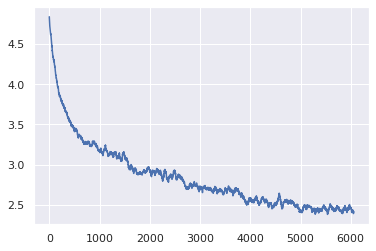

In [46]:
# Graph the loss
window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

In [47]:
## Manual Testing
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'ja',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.
Truncated input text: <jp> It has been confirmed that eight thoroughbred race horses at Randwick Racecourse</s>


In [48]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1207: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


それは、クイーンズランド・レースコースの8人乗りの競泳選手は、
それは、クイーンズランド・レースコースの8人乗りの競泳選手が、
それは、クイーンズランド・レースコースの8人乗りの競泳選手に、


In [49]:
#@title Slick Blue Translate
input_text = 'A surfboarder ran into a shark' #@param {type:"string"}
output_language = 'ja' #@param ["en", "ja", "zh"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1207: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


A surfboarder ran into a shark  ->  漁師が海鳥を発見した。
